In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.config = args
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/hbcc/hbcc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/hbcc/hbcc


In [2]:
model = np.load(sample_out+'_dcnmf.npz')

In [3]:
beta = model['beta']
theta = model['theta']
uu = beta.sum(0)
beta = beta/uu
prop = theta * uu
zz = prop.T.sum(0).reshape(theta.shape[0],1)
prop = prop/zz

df_beta = pd.DataFrame(beta.T)
df_beta.columns = dl.cols
df_theta = pd.DataFrame(prop)
df_theta.index = dl.rows

In [5]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.cols
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.rows

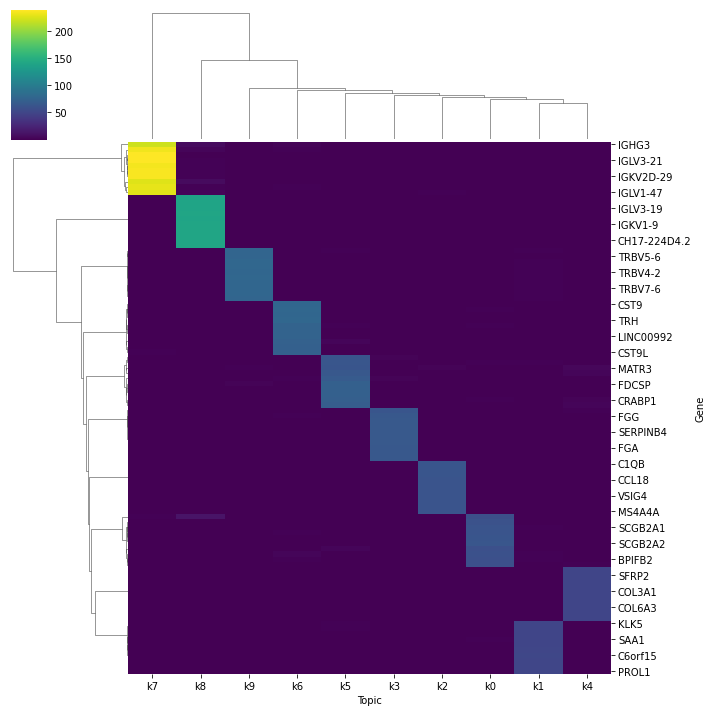

In [6]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [14]:
import umap

df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.4,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,CID3586_AAGACCTCAGCATGAG,4,6.807047,14.178740
1,CID3586_AAGGTTCGTAGTACCT,4,6.672468,12.943633
2,CID3586_ACCAGTAGTTGTGGCC,4,6.633962,13.811639
3,CID3586_ACCCACTAGATGTCGG,2,6.544075,12.659937
4,CID3586_ACTGATGGTCAACTGT,4,5.752828,9.761819
...,...,...,...,...
100059,CID4398_TCAGGTAGTACTCAAC,2,-0.108367,-1.212240
100060,CID4398_TCTATTGTCGCCATAA,7,-5.481997,7.694120
100061,CID4398_TCTTTCCCAGTAAGCG,7,-3.776369,7.044030
100062,CID4398_TGCCCATGTTACGGAG,7,-5.237583,7.372190


Text(0, 0.5, 'UMAP2')

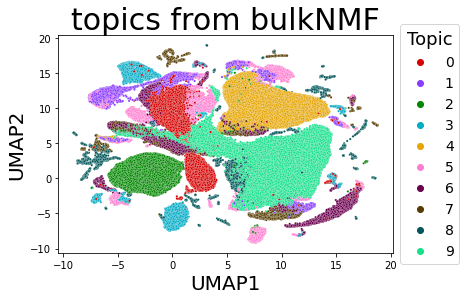

In [15]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

In [16]:
df_pl = pd.read_csv(dl.inpath+'_metadata.csv')
df_pl = df_pl.loc[:,['Unnamed: 0','celltype_major']]
df_pl.columns = ['cell','cell_type']
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')

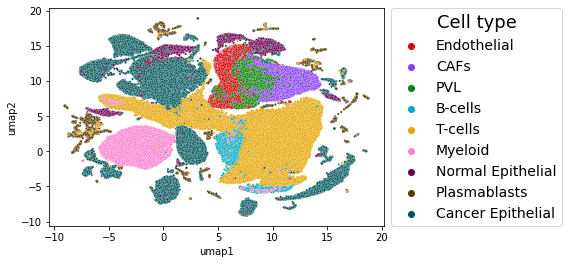

In [17]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
# p.set_xlabel("UMAP1",fontsize=20)
# p.set_ylabel("UMAP2",fontsize=20)

In [18]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match

cell                                                  \
topic_bulk              0       1       2       3       4       5       6   
cell_type                                                                   
B-cells               0.0    23.0    62.0     1.0     0.0    48.0     8.0   
CAFs                  2.0     0.0    93.0     1.0  6348.0    38.0    15.0   
Cancer Epithelial  7466.0  2162.0   143.0  4781.0   121.0  5338.0  4380.0   
Endothelial           0.0     1.0   454.0     4.0  6162.0    49.0   107.0   
Myeloid               1.0     3.0  9237.0     0.0    20.0    11.0     2.0   
Normal Epithelial   672.0  1827.0     7.0     6.0   204.0  1435.0   140.0   
PVL                   1.0    24.0    31.0     5.0  4924.0    24.0   209.0   
Plasmablasts          0.0     3.0     3.0     1.0     0.0     1.0    10.0   
T-cells               5.0   558.0    25.0     3.0     4.0   247.0  2071.0   

                                            
topic_bulk              7       8        9  
cell_type                                   
B-cells             879.0  1111.0   1074.0  
CAFs                 43.0    22.0     11.0  
Cancer Epithelial    20.0    76.0      2.0  
Endothelial         736.0    15.0     77.0  
Myeloid             139.0    94.0    168.0  
Normal Epithelial     0.0     5.0     59.0  
PVL                 127.0    42.0     36.0  
Plasmablasts        917.0  2587.0      2.0  
T-cells            1467.0   462.0  30372.0

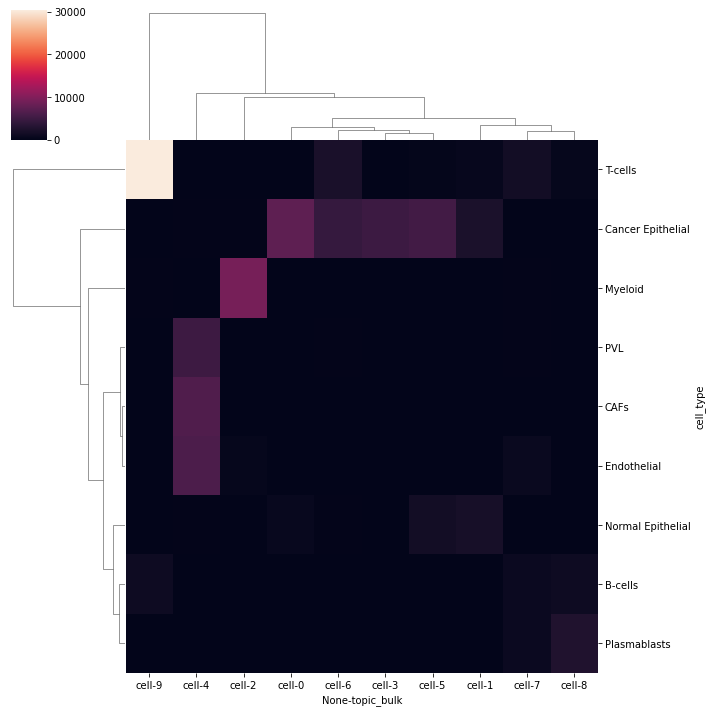

In [19]:
sns.clustermap(df_match)

In [21]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.6186203153623703